In [3]:
D.<x> = PolynomialRing(QQ)
R.<x> = PolynomialRing(QQ)
Rx = PolynomialRing(QQ, 'x')
S = PowerSeriesRing(QQ,'x', default_prec=300)
L=LaurentSeriesRing(QQ,'x', default_prec=300)
#S.<x,y>=PowerSeriesRing(QQ,default_prec=300)
# Using "R = PolynomialRing(QQ,'x')" produces an error.
# Yet using S as defined here is fine (see definition of Fraleigh4 below)
# But S = PowerSeriesRing(QQ,'x','y') also produces an error.
R.<x> = PolynomialRing(QQ)
Scplx= PowerSeriesRing(CC,'x',default_prec=300)
def pochhammer(x,n):
    return product ([x+k for k in [0..n-1]])
def cRaleigh2(alpha,beta,nu):
    pchhmrA = pochhammer(alpha,nu)
    pchhmrB = pochhammer(beta,nu)
    fnu=factorial(nu)
    answer = D(pchhmrA*pchhmrB/fnu^2)
    return answer
def term(alpha,beta,p):
    return D(1/(alpha + p) + 1/(beta + p) - 2/(1 + p))
def eRaleigh(alpha, beta, nu):
    return D(sum([term(alpha, beta, p) for p in [0..nu - 1]]))
def FstarRaleigh2(alpha,beta,u,terms):
    fsr = sum([cRaleigh2(alpha, beta, nu)*eRaleigh(alpha,beta,nu)*u^nu for nu in [1..terms]])
    return D(fsr)
def Fraleigh2(alpha,beta,u,terms): 
    return D(sum([cRaleigh2(alpha,beta,nu)*u^nu for nu in [0..terms]]))
def FstarRaleigh3(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fsr2 = FstarRaleigh2(alpha,beta,x,n)
    return D(fsr2)
def Fraleigh4(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fr2 = Fraleigh2(alpha,beta,x,n)
    return D(fr2)
def exNo3c(n,m):
    a1 = S(x)*exp(S(FstarRaleigh3(n,m,x)/Fraleigh4(n,m,x))).O(2*n)
    # S(x) instead of x in df of a1 to avoid an error message
    # after use of the stripQuotationMarks command below.
    a2 = S(a1).O(n+1)
    return a2 # applying S to argument of exp is key.
def J(n,m):
    exn = exNo3c(n+2,m)
    jnm = 1/exn.reverse()
    return jnm.O(n+1) # Jtest is faster than J, and they agree.
def normalJ(n,m):
    f = J(n,m)
    return f.truncate(n+1)
def Jcoefficient(n,m):
    f = J(n+2,m)
    f1 = f.truncate(n+1)
    f1=f1.list()
    f1=Set(f1)
    g1 = f.truncate(n)
    g1 = g1.list()
    g1 = set(g1)
    h = f1.difference(g1)
    h = h.list()
    return h[0]
def xjNewStep(n,m): 
    f=J(n,m)
    fl=f.list()
    return (sum(c*x**i*(m**3*2**6)**i for i,c in enumerate(fl)))
def xjNew(n,m):
    return xjNewStep(n-1,m)
def xjNewCoefficient(n,m):
    if n>0:return (xjNew(n,m)-xjNew(n-1,m))/x^n
    if n==0:return 1
def xjNewTest(n,m):
    return D(xjNewStep(n-1,m))
def j(n,m):return xjNew(n,m)/x

def H(n,m): # definition 8.1 (13aug21)
    jay=J(n+1,m)
    djay=x*derivative(jay,x) # bc variable is tau, not x; chain rule.
    numerator = djay^2
    denominator = jay*(jay-1)
    power = 1/(m-2)
    frac=numerator/denominator
    return ((S(frac^power)).O(n+1)).polynomial()


def H4(n,m):
    jay=j(n+1,m)
    djay=x*derivative(jay,x) # bc variable is tau, not x; chain rule.
    numerator = djay^2
    denominator = jay*(jay-2^6*m^3)
    return ((S(numerator/denominator)^(1/(m-2))).O(n+1)).polynomial()
def H6(n,m): #different than in draft 4mar21 and Mathematica.
    def base6(n,m):
        jay=j(n+1,m)
        num=(x*derivative(jay,x))^m # chain rule; variable is tau not x.
        den = expand(jay^(m-1)*(j(n+1,m)-2^6*m^3))
        return L((-1)^m*(num/den)).O(n+1)
    return (S(base6(n,m)^(1/(m-2))).polynomial())
def deltaStar(n,m):
    jay=j(n+1,m)
    djay=x*derivative(jay,x)
    numerator=djay^(2*m)
    denominator=jay^(2*m-2)*(jay-2^6*m^3)^m
    base=numerator/denominator
    xp=1/(m-2)
    power=S(base)^xp
    return (power.polynomial()).truncate(n+1)
def polynomialCoefficient(n,poly):
    return poly.list()[n]
def factorpairToFactor(factorpair):
    (monomial,exponent)=factorpair
    return monomial^exponent
def numericalfactor(polynomial):
    fp=polynomial.factor()
    lst=[factorpairToFactor(factorpair) for factorpair in fp]
    return polynomial/product(lst)
def lastfactor(polynomial):
    fp=polynomial.factor()
    fp=FiniteEnumeratedSet(fp)
    return factorpairToFactor(fp.last())
def reduced(polynomial):
    return numericalfactor(polynomial)*lastfactor(polynomial)
def stripQuotationMarks(string):
    var('x')
    return sage_eval(string,locals={'x':x})

def deltaDiamond(n,m):
    return D(S(expand((H4(n+2,m)^3)/j(n+2,m)))).truncate(n+1)

def nieburTau(n):
# The contortions below sidestep mysterious (to me) error messages...
# nieburTau is an algorith for Ramanujan''s tau from the paper
# "A formula for Ramanujan's tau-function" by Douglas Niebur.
# (He spells tau with the Greek letter.)
    def step1(n,k):
        return 35*k^4-52*k^3*n+18*k^2*n^2
    def step2(n,k):
        return sigma(k)*sigma(n-k)
    def step3(n):
        ans=0
        for k in [1..n-1]:
            ans=ans+step1(n,k)*step2(n,k)
        return 24*ans
    return n^4*sigma(n)-step3(n)

def first(list):return list[0]
def last(list):return list[-1]

def rmnjntau(n):
    answer=0
    for k in [1..n-1]:
        answer=answer+(6*k-4*(n-k))*sigma(k,3)*sigma(n-k,5)
    answer=(5*sigma(n,3)+7*sigma(n,5))*n/12-35*answer
    return answer

def element(k,listo):
    if k>len(listo):return (print("bad k"))
    return listo[k-1]

def mobiusInverseOfFunction(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        f=f+moebius(dvk)*g(n/dvk)
    return f

def mobiusInverseOfList(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        gndvk=element(n/dvk,g)
        f=f+moebius(dvk)*gndvk
    return f

def drop_first_element(listo):
    lenth=len(listo)
    answer=[]
    for k in [1..lenth-1]:
        answer=answer+[listo[k]]
    return answer

def factorSeriesFromLists(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
    return nswr

def factorSeriesFromListsWithTracking(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
            print((n,k))
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
        print("answer length: ",len(nswr))
    return nswr


def deltaDiamond(n,m):
    return D(S(expand((H(n+2,m)^3)/J(n+2,m)))).truncate(n+1)

def deltaDiamondStrike(n,m): 
    # substitute 2^6*m^3*x for x in def 9.1; not
    # yet defined in draft  21h28jul21
    f=deltaDiamond(n,m)
    fl=f.list()
    df=f.degree()
    sm=sum(fl[k]*(x*m^3*2^6)^k for k in [0..df])
    dsm=sm.degree()
    sml=sm.list()
    notzero=[]
    for entry in sml:
        if (entry!=0):notzero=notzero+[entry]
    leadingterm=notzero[0]
    sm2=sum(fl[k]*(x*m^3*2^6)^k/leadingterm for k in [0..dsm])
    return sm2
        

def deltaDiamondStrikeV2(n,m): 
    # substitute 2^6*m^3*x for x in def 9.1; not
    # yet defined in draft  21h28jul21
    f=deltaDiamond(n,m)
    fl=f.list()
    dg=f.degree()
    sm2=sum(fl[k]*(x*m^3*2^6)^k/(fl[1]*m^3*2^6) for k in [0..dg])
    return sm2

print("ok")

ok


In [3]:
for m in [3..12]:
    print("-----------------------------------------------------------------------")
    print(deltaDiamondStrike(5,m))

-----------------------------------------------------------------------
4830*x^5 - 1472*x^4 + 252*x^3 - 24*x^2 + x
-----------------------------------------------------------------------
26377322496*x^5 - 71303168*x^4 + 193536*x^3 - 512*x^2 + x
-----------------------------------------------------------------------
736994018750*x^5 - 1041128000*x^4 + 1355100*x^3 - 1480*x^2 + x
-----------------------------------------------------------------------
9341553868800*x^5 - 7616856064*x^4 + 5455872*x^3 - 3072*x^2 + x
-----------------------------------------------------------------------
74765838153790*x^5 - 38002534080*x^4 + 16490460*x^3 - 5432*x^2 + x
-----------------------------------------------------------------------
1312943704637440/3*x^5 - 441718931456/3*x^4 + 41521152*x^3 - 8704*x^2 + x
-----------------------------------------------------------------------
2037064488530526*x^5 - 475635440448*x^4 + 91937916*x^3 - 13032*x^2 + x
--------------------------------------------------------

In [4]:
difs=[]
for m in [3..30]:
    dif=deltaDiamondStrike(5,m)-deltaDiamondStrikeV2(5,m)
    difs=difs+[dif]
print(difs)
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
deltaDiamondStrike(4,3)

-1472*x^4 + 252*x^3 - 24*x^2 + x

In [6]:
deltaDiamondStrike(4,4)

-71303168*x^4 + 193536*x^3 - 512*x^2 + x

In [7]:
deltaDiamondStrike(4,5)

-1041128000*x^4 + 1355100*x^3 - 1480*x^2 + x

In [8]:
poly=D(deltaDiamondStrike(100,3))
data=[]
ls=poly.list()
for n in [1..len(ls)-1]:
    data=data+[polynomialCoefficient(n,poly)-rmnjntau(n)]
print(data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
#from 'conjecture 8.ipynb' in 'interpolations paper' folder; output snipped.
import time
import time
import pickle
wfile = open('/Users/barrybrent/14aug21no2.txt','w') # diamond series
data=[]
totalstart=time.time()/60
for m in [3..303]:
    start=time.time()/60
    data=data+[[m,deltaDiamondStrike(100,m)]]
    finish=time.time()/60
    totaltime=finish-totalstart
    print (m,finish-start,totaltime)
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [9]:
deltaDiamondStrike(5,3)

4830*x^5 - 1472*x^4 + 252*x^3 - 24*x^2 + x

In [10]:
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
data=[]
for k in [0..len(s)-1]:
    m = s[k][0]
    poly=D(s[k][1])
    data=data+[[k,poly.degree()]]
print(data) # correctness check: all of the series have the right degree.

[[0, 100], [1, 100], [2, 100], [3, 100], [4, 100], [5, 100], [6, 100], [7, 100], [8, 100], [9, 100], [10, 100], [11, 100], [12, 100], [13, 100], [14, 100], [15, 100], [16, 100], [17, 100], [18, 100], [19, 100], [20, 100], [21, 100], [22, 100], [23, 100], [24, 100], [25, 100], [26, 100], [27, 100], [28, 100], [29, 100], [30, 100], [31, 100], [32, 100], [33, 100], [34, 100], [35, 100], [36, 100], [37, 100], [38, 100], [39, 100], [40, 100], [41, 100], [42, 100], [43, 100], [44, 100], [45, 100], [46, 100], [47, 100], [48, 100], [49, 100], [50, 100], [51, 100], [52, 100], [53, 100], [54, 100], [55, 100], [56, 100], [57, 100], [58, 100], [59, 100], [60, 100], [61, 100], [62, 100], [63, 100], [64, 100], [65, 100], [66, 100], [67, 100], [68, 100], [69, 100], [70, 100], [71, 100], [72, 100], [73, 100], [74, 100], [75, 100], [76, 100], [77, 100], [78, 100], [79, 100], [80, 100], [81, 100], [82, 100], [83, 100], [84, 100], [85, 100], [86, 100], [87, 100], [88, 100], [89, 100], [90, 100], [91, 100

In [9]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
bound=5
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
print(pre_g(0))
print("=======================================================================")
dfeg=drop_first_element(g(0))
print(dfeg)
fs=factorSeriesFromLists(dfeg,bound-1)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print([m(0),fs])

37534859200*x^100 - 60754911516*x^99 + 40727164968*x^98 + 75013568546*x^97 - 49569988608*x^96 + 51494658600*x^95 - 64496363904*x^94 - 13316478336*x^93 - 27442896384*x^92 + 9673645072*x^91 + 13173496560*x^90 - 24992917110*x^89 + 45164021760*x^88 + 32358470760*x^87 + 411016992*x^86 - 33355661220*x^85 + 6211086336*x^84 - 29335099668*x^83 - 7394890608*x^82 + 1665188361*x^81 + 4767866880*x^80 + 38116845680*x^79 + 3494159424*x^78 - 8951543328*x^77 - 15693610240*x^76 - 6425804700*x^75 + 4373119536*x^74 + 1463791322*x^73 - 9600560640*x^72 + 9791485272*x^71 + 1940964480*x^70 + 4698104544*x^69 + 10165534848*x^68 - 15481826884*x^67 - 3233333376*x^66 - 2790474540*x^65 + 2699296768*x^64 + 1902838392*x^63 + 1268236032*x^62 + 6956478662*x^61 - 1791659520*x^60 - 5189203740*x^59 - 3081759120*x^58 + 2686677840*x^57 - 1414533120*x^56 + 2582175960*x^55 + 1758697920*x^54 - 1596055698*x^53 + 850430336*x^52 - 1740295368*x^51 + 611981400*x^50 - 1696965207*x^49 + 248758272*x^48 + 2687348496*x^47 - 447438528*x^

In [10]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
bound=98
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
print(pre_g(0))
print("=======================================================================")
dfeg=drop_first_element(g(0))
print(dfeg)
fs=factorSeriesFromLists(dfeg,bound-1)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print([m(0),fs])

37534859200*x^100 - 60754911516*x^99 + 40727164968*x^98 + 75013568546*x^97 - 49569988608*x^96 + 51494658600*x^95 - 64496363904*x^94 - 13316478336*x^93 - 27442896384*x^92 + 9673645072*x^91 + 13173496560*x^90 - 24992917110*x^89 + 45164021760*x^88 + 32358470760*x^87 + 411016992*x^86 - 33355661220*x^85 + 6211086336*x^84 - 29335099668*x^83 - 7394890608*x^82 + 1665188361*x^81 + 4767866880*x^80 + 38116845680*x^79 + 3494159424*x^78 - 8951543328*x^77 - 15693610240*x^76 - 6425804700*x^75 + 4373119536*x^74 + 1463791322*x^73 - 9600560640*x^72 + 9791485272*x^71 + 1940964480*x^70 + 4698104544*x^69 + 10165534848*x^68 - 15481826884*x^67 - 3233333376*x^66 - 2790474540*x^65 + 2699296768*x^64 + 1902838392*x^63 + 1268236032*x^62 + 6956478662*x^61 - 1791659520*x^60 - 5189203740*x^59 - 3081759120*x^58 + 2686677840*x^57 - 1414533120*x^56 + 2582175960*x^55 + 1758697920*x^54 - 1596055698*x^53 + 850430336*x^52 - 1740295368*x^51 + 611981400*x^50 - 1696965207*x^49 + 248758272*x^48 + 2687348496*x^47 - 447438528*x^

In [11]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
bound=98
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..2]:
    print("************************************************************************")
    print("index: ",index)
    print(pre_g(index))
    print("=======================================================================")
    dfeg=drop_first_element(g(index))
    print(dfeg)
    fs=factorSeriesFromLists(dfeg,bound-1)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print([m(index),fs])

************************************************************************
index:  0
37534859200*x^100 - 60754911516*x^99 + 40727164968*x^98 + 75013568546*x^97 - 49569988608*x^96 + 51494658600*x^95 - 64496363904*x^94 - 13316478336*x^93 - 27442896384*x^92 + 9673645072*x^91 + 13173496560*x^90 - 24992917110*x^89 + 45164021760*x^88 + 32358470760*x^87 + 411016992*x^86 - 33355661220*x^85 + 6211086336*x^84 - 29335099668*x^83 - 7394890608*x^82 + 1665188361*x^81 + 4767866880*x^80 + 38116845680*x^79 + 3494159424*x^78 - 8951543328*x^77 - 15693610240*x^76 - 6425804700*x^75 + 4373119536*x^74 + 1463791322*x^73 - 9600560640*x^72 + 9791485272*x^71 + 1940964480*x^70 + 4698104544*x^69 + 10165534848*x^68 - 15481826884*x^67 - 3233333376*x^66 - 2790474540*x^65 + 2699296768*x^64 + 1902838392*x^63 + 1268236032*x^62 + 6956478662*x^61 - 1791659520*x^60 - 5189203740*x^59 - 3081759120*x^58 + 2686677840*x^57 - 1414533120*x^56 + 2582175960*x^55 + 1758697920*x^54 - 1596055698*x^53 + 850430336*x^52 - 1740295368*x^51 +

In [12]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
data=[]
bound=98
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..2]:
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    data=data+[[m(index),fs]]
print(data)
print(len(data))

[[3, [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]], [4, [512, -62720, 16951808, -4696409600, 1391609669120, -429364757289216, 136262485847347712, -44144916773640667136, 14528625161272525586432, -4841315268320011411771136, 1629547469970285501302225408, -553063237951753942229722037760, 189020549847625515732394072765952, -64986130044499936284939172987264256, 22457105973920349979419163975156620800, -7795094801463628654515398168607740395520, 2716369209886800862025389244048019250093568, -949864270554054153387379164431903340497731584, 333178364883796374945493031657301666080322472448, -117191667631752230221850347432095666297879679709696, 413241350063117037

In [13]:
print(data[0])

[3, [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]]


In [14]:
print(data[1])

[4, [512, -62720, 16951808, -4696409600, 1391609669120, -429364757289216, 136262485847347712, -44144916773640667136, 14528625161272525586432, -4841315268320011411771136, 1629547469970285501302225408, -553063237951753942229722037760, 189020549847625515732394072765952, -64986130044499936284939172987264256, 22457105973920349979419163975156620800, -7795094801463628654515398168607740395520, 2716369209886800862025389244048019250093568, -949864270554054153387379164431903340497731584, 333178364883796374945493031657301666080322472448, -117191667631752230221850347432095666297879679709696, 41324135006311703732703814648195881787196634566130176, -14604837262856142405015368184502332318107763857680040192, 5172349983397103397904385879768526093169245267356957061632, -1835273671042617649369384764255405976027283408567411505168384, 652331580190151668003268080444394052185941925442348697486622720, -232236993720546179148095370300012357133166096555596522700383549184, 828013316330927742082804867289333552139290

In [15]:
print(data[2])

[5, [1480, -260640, 116176840, -46724443800, 20692010946504, -9528409618809120, 31614866949128678520/7, -15296462877078197145000/7, 22555590366415575439217000/21, -11225116525511267138807671712/21, 5642769886319267252391881551720/21, -2860210098734795846245041143041400/21, 18979000589931538505094442080928718920/273, -9745021767323535071302591105056111595040/273, 35205603039245837008116874798704319099100152/1911, -18250603154004650414124392424445843602866825000/1911, 161469820337311550151996579288024137340474140921720/32487, -84326084629129011451890237228096200928479236488716000/32487, 132524523817600223871571564001957824171996322721982539880/97461, -69616793370539071743990135617034683369025706258912127211640/97461, 1745820460984414877404856080644896429613411334101950036475080/4641, -135458943916511527007871474877302292308945413580213800122988359520/682227, 1647875981685771278749040841350667888351344727363517528055864615304040/15691221, -2910811090773429718068329534183136020611978122156

In [18]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
data=[]
bound=98
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
print(len(s))

301


In [19]:
print(g(300))

[0, 1, -663208824, 229092456951540252, -55384220442594033670574272, 10577234035863782522539412931400830, -1702579344515433805022932366663948260719136, 240293088602411315749079659385276646085280239416920, -213673566967055080523395607222838458943467242520030783894016/7, 3555167658859162546226094120092166778110280709723257630969143855861, -384829783206412190890980754854396415197503520763612781386982158882488994320, 39118194263355788846405150782826704324278123669927742722424056655493847346935733812, -41410205706458324513177613147425799048435573554567844811475859217369049892633482978326712064/11, 3797440366761823206742762315806892129500981021248721639583255062347440904878088297286661563805627762/11, -4336778014336440960564563965733949384568617107021387696237141457675450949355113278021663365974495668882293952/143, 17961901191229863427659151837875741718091762971147848498772639285132377847313804593806824437721558022594930975854654520/7007, -20945971364275946282191881682407196539306531279606368

In [20]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
data=[]
bound=98
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..3]:
    print("index: ",index)
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    data=data+[[m(index),fs]]

wfile = open('/Users/barrybrent/26aug22no3.txt','wb') # deltaDiamondStrike product exponents
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

index:  0
index:  1
index:  2
index:  3


In [22]:
import pickle
rfile = open('/Users/barrybrent/26aug22no3.txt','rb') # deltaDiamondStrike product exponents
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

4


In [23]:
import pickle
rfile = open('/Users/barrybrent/26aug22no3.txt','rb') # deltaDiamondStrike product exponents
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
for k in [0..3]:
    print(s[k])

[3, [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]]
[4, [512, -62720, 16951808, -4696409600, 1391609669120, -429364757289216, 136262485847347712, -44144916773640667136, 14528625161272525586432, -4841315268320011411771136, 1629547469970285501302225408, -553063237951753942229722037760, 189020549847625515732394072765952, -64986130044499936284939172987264256, 22457105973920349979419163975156620800, -7795094801463628654515398168607740395520, 2716369209886800862025389244048019250093568, -949864270554054153387379164431903340497731584, 333178364883796374945493031657301666080322472448, -117191667631752230221850347432095666297879679709696, 41324135006311703732

In [24]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
data=[]
bound=98
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..300]:
    print("index: ",index)
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    data=data+[[m(index),fs]]

wfile = open('/Users/barrybrent/26aug22no4.txt','wb') # deltaDiamondStrike product exponents
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

index:  0
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
index:  10
index:  11
index:  12
index:  13
index:  14
index:  15
index:  16
index:  17
index:  18
index:  19
index:  20
index:  21
index:  22
index:  23
index:  24
index:  25
index:  26
index:  27
index:  28
index:  29
index:  30
index:  31
index:  32
index:  33
index:  34
index:  35
index:  36
index:  37
index:  38
index:  39
index:  40
index:  41
index:  42
index:  43
index:  44
index:  45
index:  46
index:  47
index:  48
index:  49
index:  50
index:  51
index:  52
index:  53
index:  54
index:  55
index:  56
index:  57
index:  58
index:  59
index:  60
index:  61
index:  62
index:  63
index:  64
index:  65
index:  66
index:  67
index:  68
index:  69
index:  70
index:  71
index:  72
index:  73
index:  74
index:  75
index:  76
index:  77
index:  78
index:  79
index:  80
index:  81
index:  82
index:  83
index:  84
index:  85
index:  86
index:  87
index:  88
index:  89
index:  90
index:  9

In [25]:
import pickle
rfile = open('/Users/barrybrent/26aug22no4.txt','rb') # deltaDiamondStrike product exponents
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

301


In [27]:
import pickle
rfile = open('/Users/barrybrent/26aug22no4.txt','rb') # deltaDiamondStrike product exponents
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(s[0])

[3, [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]]


In [28]:
import pickle
rfile = open('/Users/barrybrent/26aug22no4.txt','rb') # deltaDiamondStrike product exponents
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(s[300])

[303, [663208824, -9169485167413176, 684651952131779302754424, -3527791866768828438199784624376, 477558620709064804098792996330537234552, -7366861131439566565316431454735999156196143928, 2471502377234974574806443535251432900740881810340872776/7, -7659198531025672998387343739120952872416462379261086280236488/7, 2420020388017437822123560274576920229954847402442769165105661968334920/7, -28239392737993084581066518938681544544125182796159026545773429166271860471432/7, 15684384611986651203116945759839575967513112554198479431794089490749661588308227203608/77, -136757061417616146622305800598771232285005040106931090285278182018931886686227822396990116120/77, 156610248434719139372487182091260701276628122019631138007759963368301638552895111444362917207313234744/1001, -2356635577175611201715884295388400762097980184689899302886086247055177869254778467783573933415034692128180088/1001, 12584211546397249141864665308453385883628035393255141923636977435069799280253701603063687504130447188111525529910250

In [ ]:
# interpolating polynomials
import pickle
rfile = open('/Users/barrybrent/30aug22no1.txt','rb') #deltaDiamondWt12Strike Euler exponents
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
polydata=[]
import time
wfile = open('/Users/barrybrent/30aug22no2.txt','wb') #deltaDiamondWt12Strike Euler exponent polynomials
for exponentnumber in [1..199]:
    start = time.time()
    data=[]
    for k in [0..len(s)-1]:
        m = s[k][0]
        exponents=s[k][1]
        exponent=exponents[exponentnumber-1]
        data=data+[(m,exponent)]
    rl=Rx.lagrange_polynomial(data)
    polydata=polydata+[[exponentnumber,rl]] 
    finish = time.time()
    print([exponentnumber,finish-start])
t = pickle.dumps(str(polydata))
wfile.write(t)
wfile.close()

In [ ]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/14aug21no2.txt','rb')  # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
data=[]
bound=98
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..300]:
    print("index: ",index)
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    data=data+[[m(index),fs]]

wfile = open('/Users/barrybrent/26aug22no4.txt','wb') # deltaDiamondStrike product exponents
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

In [3]:
import time
import pickle

data=[]
start=time.time()
for m in [3..6]:
    ds=deltaDiamondStrike(20,m)
    data=data+[[m,ds]]
    finish=time.time()
    print([m,finish-start])
    
wfile = open('/Users/barrybrent/31aug22TEST.txt','wb') # deltaDiamondStrike series TEST
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

[3, 0.34318113327026367]
[4, 0.5160810947418213]
[5, 0.908850908279419]
[6, 1.2087481021881104]


In [5]:
rfile = open('/Users/barrybrent/31aug22TEST.txt','rb') # deltaDiamondStrike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
for n in [0..len(s)-1]:
    print(s[n])

[3, -7109760*x^20 + 10661420*x^19 + 2727432*x^18 - 6905934*x^17 + 987136*x^16 + 1217160*x^15 + 401856*x^14 - 577738*x^13 - 370944*x^12 + 534612*x^11 - 115920*x^10 - 113643*x^9 + 84480*x^8 - 16744*x^7 - 6048*x^6 + 4830*x^5 - 1472*x^4 + 252*x^3 - 24*x^2 + x]
[4, -8885587553197547463665164864453614691870643847168*x^20 + 23998815890591929587509717352513537213596696576*x^19 - 64817679270209892305674204015964715730599936*x^18 + 175064118376890949951845182846739589103616*x^17 - 472825406403644606791706995438729035776*x^16 + 1277039904085124165880401851764965376*x^15 - 3449118627169457342769029240061952*x^14 + 9315620652286804129651563167744*x^13 - 25160279340226407348918288384*x^12 + 67954640928064009830137856*x^11 - 183536643640257278902272*x^10 + 495708598119841136640*x^9 - 1338844522817257472*x^8 + 3616043159257088*x^7 - 9766352977920*x^6 + 26377322496*x^5 - 71303168*x^4 + 193536*x^3 - 512*x^2 + x]
[5, -42557363696386086664355872310668612753341459908593750000000/97461*x^20 + 73028424994158

In [2]:
import time
import pickle

data=[]
start=time.time()
for m in [3..600]:
    ds=deltaDiamondStrike(200,m)
    data=data+[[m,ds]]
    finish=time.time()
    print([m,finish-start])
    
wfile = open('/Users/barrybrent/31aug22no1.txt','wb') # deltaDiamondStrike long series
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

[3, 43.099371671676636]
[4, 70.76544284820557]
[5, 124.01101088523865]
[6, 149.09590983390808]
[7, 208.51938390731812]
[8, 253.86010766029358]
[9, 318.5499987602234]
[10, 359.44970774650574]
[11, 424.23941683769226]
[12, 479.80386686325073]
[13, 549.3391268253326]
[14, 593.7103669643402]
[15, 670.6954047679901]
[16, 725.1539289951324]
[17, 798.9764218330383]
[18, 848.6797649860382]
[19, 920.0855069160461]
[20, 984.6708660125732]
[21, 1065.0280437469482]
[22, 1113.9446549415588]
[23, 1186.8967397212982]
[24, 1254.1104497909546]
[25, 1333.7919218540192]
[26, 1389.5149338245392]
[27, 1469.5869748592377]
[28, 1538.8244218826294]
[29, 1615.2942049503326]
[30, 1675.2667648792267]
[31, 1751.5784640312195]
[32, 1814.0756258964539]
[33, 1902.636757850647]
[34, 1959.5931978225708]
[35, 2050.1533839702606]
[36, 2125.1339359283447]
[37, 2207.7841186523438]
[38, 2265.5551488399506]
[39, 2352.3440198898315]
[40, 2426.050151824951]
[41, 2503.0481219291687]
[42, 2562.002401828766]
[43, 2626.8600127696

[329, 24342.903288841248]
[330, 24421.011333942413]
[331, 24507.61073064804]
[332, 24588.224467992783]
[333, 24683.62860393524]
[334, 24752.177598953247]
[335, 24842.070322990417]
[336, 24927.68411707878]
[337, 25015.904237747192]
[338, 25086.595148801804]
[339, 25179.647522687912]
[340, 25261.6515789032]
[341, 25352.567091941833]
[342, 25425.19187092781]
[343, 25518.631072044373]
[344, 25596.401173830032]
[345, 25693.85075879097]
[346, 25759.399265766144]
[347, 25844.887398958206]
[348, 25930.05444574356]
[349, 26017.64770579338]
[350, 26091.9895529747]
[351, 26185.520000696182]
[352, 26263.212060928345]
[353, 26350.264236688614]
[354, 26422.701596975327]
[355, 26515.5163898468]
[356, 26593.267231941223]
[357, 26691.470362901688]
[358, 26758.559913873672]
[359, 26847.78849172592]
[360, 26935.007245779037]
[361, 27027.06854891777]
[362, 27094.444011688232]
[363, 27191.459812879562]
[364, 27277.450022935867]
[365, 27370.070611953735]
[366, 27442.180857896805]
[367, 27529.9991607666]
[36

In [2]:
print(deltaDiamondStrike(20,3))

-7109760*x^20 + 10661420*x^19 + 2727432*x^18 - 6905934*x^17 + 987136*x^16 + 1217160*x^15 + 401856*x^14 - 577738*x^13 - 370944*x^12 + 534612*x^11 - 115920*x^10 - 113643*x^9 + 84480*x^8 - 16744*x^7 - 6048*x^6 + 4830*x^5 - 1472*x^4 + 252*x^3 - 24*x^2 + x


In [3]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/31aug22no1.txt','rb') # deltaDiamondStrike long series
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
print(s[0])

[3, -2154174528000*x^200 + 728391402200*x^199 + 1458117876384*x^198 - 2876091504354*x^197 + 2497932784704*x^196 - 703199584080*x^195 - 1800325645104*x^194 + 5442387685442*x^193 + 680222785536*x^192 + 2762403350592*x^191 - 1235871806400*x^190 + 1226984915520*x^189 - 3955776986112*x^188 - 3691995187608*x^187 + 319595480064*x^186 - 880090306620*x^185 + 1574983618560*x^184 + 1753032622824*x^183 - 232167481728*x^182 - 996774496018*x^181 + 807974455680*x^180 + 1681384224780*x^179 + 599830010640*x^178 - 1307679342480*x^177 + 527734751232*x^176 + 426959023400*x^175 - 776603298240*x^174 - 950387449578*x^173 + 25209042176*x^172 - 1211595753060*x^171 + 800535869280*x^170 - 1458379197393*x^169 - 356462346240*x^168 + 2754833892216*x^167 + 704042392032*x^166 + 650708341920*x^165 - 453553290624*x^164 - 357832759588*x^163 - 39964520664*x^162 - 312162946368*x^161 - 950091448320*x^160 - 402206035896*x^159 - 914804296320*x^158 + 1315116754406*x^157 + 214308444672*x^156 - 255232501440*x^155 + 214837039872

In [4]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/31aug22no1.txt','rb') # deltaDiamondStrike long series
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
data=[]
bound=200
def m(n):return s[n][0] # m(n) = Hecke group index
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..199]:
    print("index: ",index)
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    data=data+[[m(index),fs]]

wfile = open('/Users/barrybrent/2sept22no3.txt','wb') # deltaDiamondStrike long product exponents
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

index:  0
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
index:  10
index:  11
index:  12
index:  13
index:  14
index:  15
index:  16
index:  17
index:  18
index:  19
index:  20
index:  21
index:  22
index:  23
index:  24
index:  25
index:  26
index:  27
index:  28
index:  29
index:  30
index:  31
index:  32
index:  33
index:  34
index:  35
index:  36
index:  37
index:  38
index:  39
index:  40
index:  41
index:  42
index:  43
index:  44
index:  45
index:  46
index:  47
index:  48
index:  49
index:  50
index:  51
index:  52
index:  53
index:  54
index:  55
index:  56
index:  57
index:  58
index:  59
index:  60
index:  61
index:  62
index:  63
index:  64
index:  65
index:  66
index:  67
index:  68
index:  69
index:  70
index:  71
index:  72
index:  73
index:  74
index:  75
index:  76
index:  77
index:  78
index:  79
index:  80
index:  81
index:  82
index:  83
index:  84
index:  85
index:  86
index:  87
index:  88
index:  89
index:  90
index:  9

In [5]:
import pickle
rfile = open('/Users/barrybrent/2sept22no3.txt','rb') # deltaDiamondStrike long product exponents
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))
print(s[0])

200
[3, [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]]


In [4]:
# output snipped
# interpolating polynomials
import pickle
rfile = open('/Users/barrybrent/2sept22no3.txt','rb') # deltaDiamondStrike long product exponents
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
polydata=[]
import time
wfile = open('/Users/barrybrent/2sept22no4.txt','wb') #deltaDiamondStrike Euler long exponent polynomials
for n in [1..199]:
    start = time.time()
    data=[]
    for k in [0..len(s)-1]:
        m = s[k][0]
        exponents=s[k][1]
        exponent=exponents[n-1]
        data=data+[(m,exponent)]
    rl=Rx.lagrange_polynomial(data)
    polydata=polydata+[[n,rl]] 
    finish = time.time()
    print([n,finish-start])
t = pickle.dumps(str(polydata))
wfile.write(t)
wfile.close()

[1, 0.02944207191467285]
[2, 0.06865096092224121]
[3, 0.028873920440673828]
[4, 0.02915811538696289]
[5, 0.029493093490600586]
[6, 0.02970290184020996]
[7, 0.07133197784423828]
[8, 0.029994964599609375]
[9, 0.031221866607666016]
[10, 0.030781030654907227]
[11, 0.030450820922851562]
[12, 0.0713498592376709]
[13, 0.03250718116760254]
[14, 0.03126239776611328]
[15, 0.03175687789916992]
[16, 0.07544493675231934]
[17, 0.03298306465148926]
[18, 0.032988786697387695]
[19, 0.03405189514160156]
[20, 0.03550887107849121]
[21, 0.07429981231689453]
[22, 0.03958296775817871]
[23, 0.03934478759765625]
[24, 0.03893899917602539]
[25, 0.07988190650939941]
[26, 0.04236793518066406]
[27, 0.04398918151855469]
[28, 0.04291725158691406]
[29, 0.04591012001037598]
[30, 0.08370518684387207]
[31, 0.04878687858581543]
[32, 0.054524898529052734]
[33, 0.05081510543823242]
[34, 0.053559064865112305]
[35, 0.09053397178649902]
[36, 0.05712318420410156]
[37, 0.060056209564208984]
[38, 0.05773305892944336]
[39, 0.09940

exponent:  1
polynomial:  24*x^3 - 48*x^2 - 64*x
roots:
[(-0.914854215512676, 1), (0.000000000000000, 1), (2.91485421551268, 1)]


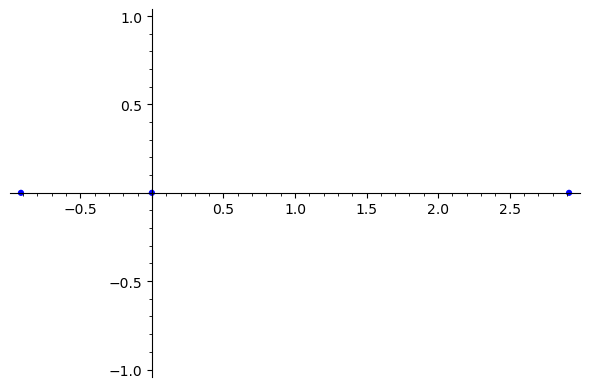

In [11]:
import pickle
rfile = open('/Users/barrybrent/2sept22no4.txt','rb') #deltaDiamondStrike Euler long exponent polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
for k in [0..0]:
    print("=====================================================================================")
    print("exponent: ",s[k][0])
    points=[]
    poly=s[k][1]
    print("polynomial: ",poly)
    poly=R(poly)
    pr=poly.roots(CC)
    print("roots:")
    print(pr)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        roots=roots+[rootpair]
       
    rootplot=list_plot(roots,color='blue',size=20)
    show(rootplot)

exponent:  199
polynomial:  183439109479397343803013991113369989788896029364172036203470136283399040963120590397222836432767139764558698663991636071753548913322231572150120162158001482859707612140792790614839302737916376761608080105499793868487157083308706861288539349678071346598026966678502250160048232375701700898645293358194772799733326217369440600540366997799175717167253633092750195164274146521842033673328709236326620813014800324304442377296941930943919845792442857971403377465372128408137289207698494304309762661951286158728109486987143029636429723368661289137703563359013171484105091605349452846978921699997605075529273484777336698846917920463208261536418293967136065220505987493776879379849950285228789069563267627712430008758724223549451301059727996775092322287066286171971124188099693834339376496833444812300232582331734451514683274955582200841948285592128837018967347648397787126280727291034414166909512845801555330635631926451126669914072722848955076727304824350578752974749398518861198

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j:  121
j:  122
j:  123
j:  124
j:  125
j:  126
j:  127
j:  128
j:  129
j:  130
j:  131
j:  132
j:  133
j:  134
j:  135
j:  136
j:  137
j:  13

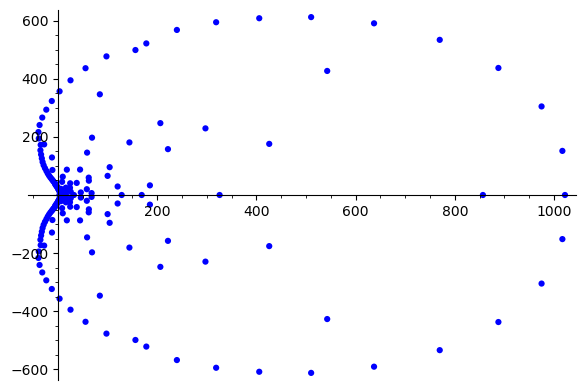

In [14]:
import pickle
rfile = open('/Users/barrybrent/2sept22no4.txt','rb') #deltaDiamondStrike Euler long exponent polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
for k in [198..198]:
    print("=====================================================================================")
    print("exponent: ",s[k][0])
    points=[]
    poly=s[k][1]
    print("polynomial: ",poly)
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        print("j: ",j)
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        roots=roots+[rootpair]
       
    rootplot=list_plot(roots,color='blue',size=20)
    show(rootplot)